### Setup

In [1]:
# core
import pydicom, numpy as np, matplotlib.pyplot as plt
from pydicom import dcmread

# image processing
from skimage.filters import threshold_otsu
from scipy.signal import butter, filtfilt, medfilt
import cv2  # OpenCV
from matplotlib.widgets import RectangleSelector

# handy utils
from dataclasses import dataclass


### 1. Load DICOM and extract cine frames, Choose / detect spectral frames

It is better to run 1_panel_roi.py and draw the rectangle covering the blood flow area. Change name: A0005

image size: 960 x 1280


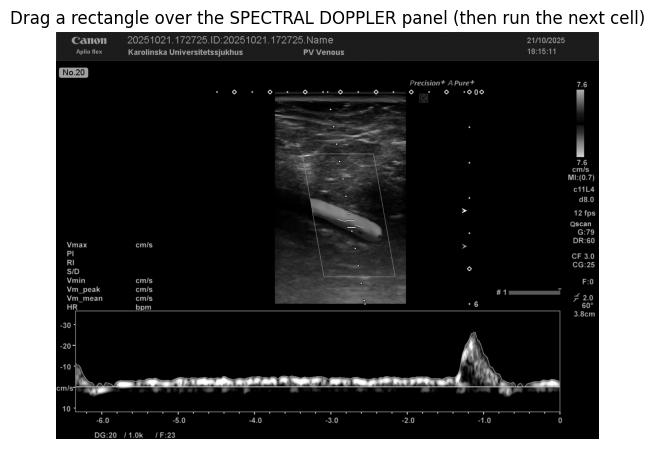

In [7]:
ds = dcmread("./A0005")

img = ds.pixel_array
if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)
H, W = img.shape
print(f"image size: {H} x {W}")

# 3) interactive ROI picker
roi_coords = {}   # will get populated by the callback

fig, ax = plt.subplots(figsize=(7,6))
ax.imshow(img, cmap='gray')
ax.set_title("Drag a rectangle over the SPECTRAL DOPPLER panel (then run the next cell)")
ax.axis('off')

def onselect(eclick, erelease):
    # Ensure top-left / bottom-right ordering
    x0, y0 = int(min(eclick.xdata,  erelease.xdata)), int(min(eclick.ydata,  erelease.ydata))
    x1, y1 = int(max(eclick.xdata,  erelease.xdata)), int(max(eclick.ydata,  erelease.ydata))
    roi_coords['x0'], roi_coords['y0'], roi_coords['x1'], roi_coords['y1'] = x0, y0, x1, y1
    print("ROI set:", roi_coords)

rs = RectangleSelector(ax, onselect,
                       useblit=False, button=[1],  # left-click drag
                       interactive=True, minspanx=10, minspany=10)
plt.show()

### 2. Select the spectral panel ROI
Many ultrasound clips include B-mode + spectral + text overlays. Start simple: manual ROI once, then reuse for all frames.

ROI shape: (237, 1142)  (y:658->895, x:45->1187)


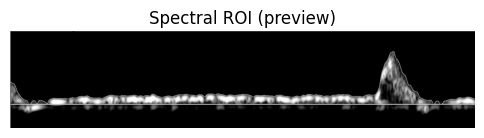

In [8]:
roi_coords= {'x0': 45, 'y0': 658, 'x1': 1187, 'y1': 895}

y0, y1, x0, x1 = roi_coords['y0'], roi_coords['y1'], roi_coords['x0'], roi_coords['x1']

spec = img[y0:y1, x0:x1]
print(f"ROI shape: {spec.shape}  (y:{y0}->{y1}, x:{x0}->{x1})")

plt.figure(figsize=(6,4))
plt.imshow(spec, cmap='gray')
plt.title("Spectral ROI (preview)")
plt.axis('off')
plt.show()

### 3. Calibrate pixels → time (s) and velocity (cm/s)
You need two scale factors:

Horizontal (px → s): if dt is known from DICOM you’re done; otherwise use the on-screen sweep speed grid (e.g., “2 s” span) and click two vertical gridlines.

Vertical (px → cm/s): click two tick labels (e.g., 0 and 100 cm/s) or use a known vertical scale bar.

Minimal manual approach:

In [ ]:
## Run 2_calibration.py - Change the ROI and adjust seconds_span and vel_span

### 4. Preprocess each frame (crop → normalize)

image size: 960 x 1280


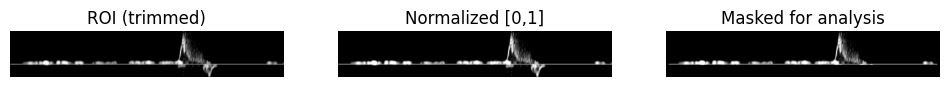

In [39]:
# 3. Preprocess (crop margins -> normalize -> make a clean "analysis image")

import numpy as np, cv2, matplotlib.pyplot as plt
import pydicom
from matplotlib.widgets import RectangleSelector

ds = pydicom.dcmread("./A0023")
img = ds.pixel_array
if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)
H, W = img.shape
print(f"image size: {H} x {W}")

roi_coords= {'x0': 107, 'y0': 704, 'x1': 1188, 'y1': 891}

y0, y1, x0, x1 = roi_coords['y0'], roi_coords['y1'], roi_coords['x0'], roi_coords['x1']

spec = img[y0:y1, x0:x1]

px_per_s = 179.92 
px_per_cms = 2.435
v0_row = 159

cal = {"px_per_s": float(px_per_s), "px_per_cms": float(px_per_cms), "v0_row": int(v0_row)}

# --- 3.1 (optional) trim tiny margins to remove axis ticks/text inside the ROI ---
# tweak these if you still see labels in the preview
pad_top, pad_bottom, pad_left, pad_right = 4, 4, 4, 4
roi = spec[pad_top: spec.shape[0]-pad_bottom,
           pad_left: spec.shape[1]-pad_right]

# --- 3.2 convert to float32 and robust-normalize to [0,1] (P2–P98) ---
im = roi.astype(np.float32)
p2, p98 = np.percentile(im, [2, 98])
im = np.clip((im - p2) / (p98 - p2 + 1e-6), 0, 1)

# (optional) local contrast boost (CLAHE) if the strip looks very flat)
use_clahe = False
if use_clahe:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    im = clahe.apply((im*255).astype(np.uint8)).astype(np.float32)/255.0

# --- 3.3 build an analysis mask to ignore non-informative regions ---
H, W = im.shape
mask = np.ones_like(im, dtype=np.uint8)

# Exclude top/bottom 1% (possible borders)
b = max(1, int(0.01*H))
mask[:b,:] = 0; mask[-b:,:] = 0

# Exclude a wall-filter band around 0 cm/s (±5 cm/s) which is often dark
band = int(9.5 * cal["px_per_cms"])
r0 = np.clip(cal["v0_row"] - pad_top, 0, H-1)  # adjust for the pad we removed
mask[max(0, r0-band): min(H, r0+band), :] = 0

# Optional: exclude left/right 1% (axes/labels)
b2 = max(1, int(0.01*W))
mask[:, :b2] = 0; mask[:, -b2:] = 0

# --- 3.4 final image used for thresholding/tracing ---
im_for_thresh = im.copy()
im_for_thresh[mask==0] = 0.0

# --- 3.5 sanity check preview ---
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(roi, cmap='gray'); axs[0].set_title("ROI (trimmed)"); axs[0].axis('off')
axs[1].imshow(im, cmap='gray'); axs[1].set_title("Normalized [0,1]"); axs[1].axis('off')
axs[2].imshow(im_for_thresh, cmap='gray'); axs[2].set_title("Masked for analysis"); axs[2].axis('off')
plt.show()


### 5. Otsu threshold + grid search and 2D median despeckle
Wadehn & Heldt use Otsu then try nearby thresholds, with a 2D median filter roughly 0.03 s × 5 cm/s (convert to pixels via calibration)

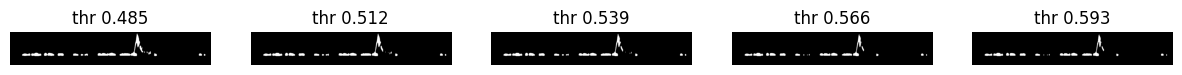

In [40]:
import numpy as np
from skimage.filters import threshold_otsu
from scipy.ndimage import median_filter

# --- 4) Otsu threshold on the masked image ---
# If you still have `mask` from preprocessing, use it to compute Otsu on just the valid pixels.
valid = im_for_thresh[im_for_thresh > 0]  # masked-out regions are zeros
thr0 = threshold_otsu(valid) if valid.size else threshold_otsu(im_for_thresh)

# Grid around Otsu (as in the paper)
thr_grid = [0.90*thr0, 0.95*thr0, thr0, 1.05*thr0, 1.10*thr0]

# --- 4.1) Build the 2D median kernel from physical sizes ---
# ~0.03 s horizontally × 5 cm/s vertically  -> convert to pixels with your calibration
kx = max(3, int(round(0.03 * cal["px_per_s"])))   # pixels along time axis
ky = max(3, int(round(5.0  * cal["px_per_cms"]))) # pixels along velocity axis
# scipy's median_filter accepts rectangular kernels:
kernel_size = (ky | 1, kx | 1)                    # force odd sizes

# --- 4.2) Binarize + despeckle for each threshold candidate ---
binary_candidates = []
for thr in thr_grid:
    b = (im_for_thresh >= thr).astype(np.uint8)
    b = median_filter(b, size=kernel_size, mode="nearest")  # 2D median despeckle
    binary_candidates.append(b)

# Quick peek at what you produced (optional)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(binary_candidates), figsize=(3*len(binary_candidates), 3))
for i,bi in enumerate(binary_candidates):
    axs[i].imshow(bi, cmap="gray"); axs[i].set_title(f"thr {thr_grid[i]:.3f}"); axs[i].axis('off')
plt.show()


### 6. Envelope tracing (column-wise maximum after despeckle)
For each threshold, despeckle, then for each time column take the highest “on” pixel as the maximal velocity. Finally, pick the best candidate by a beat-quality score (next step). This follows their column-wise envelope extraction. 

In [41]:
import numpy as np
from scipy.signal import butter, filtfilt, medfilt

def trace_envelope_from_binary(bi):
    """bi: (H,W) uint8 binary image after despeckle.
       Returns: env_row_px (length W) = topmost 'on' pixel per column (NaN if none)."""
    H, W = bi.shape
    env = np.full(W, np.nan, np.float32)
    for x in range(W):
        ys = np.nonzero(bi[:, x])[0]  # rows where pixel is 'on'
        if ys.size:
            env[x] = ys.min()          # topmost bright pixel
    return env

def pxrow_to_velocity_cm_s(row_px, cal):
    dy = (cal["v0_row"] - row_px)  # pixels above 0 cm/s line
    return dy / cal["px_per_cms"]

def smooth_envelope(v_cm_s, fs):
    v = medfilt(v_cm_s, 3)         # short 1D median to remove spikes
    fc = min(16.0, 0.4*fs)         # ~16 Hz low-pass (scale to your sampling)  (Wadehn post-filter)
    b, a = butter(4, fc/(fs/2), btype="low")
    return filtfilt(b, a, np.nan_to_num(v, nan=np.nanmedian(v)))

# Trace, convert, smooth for each threshold candidate
fs_env = cal["px_per_s"]          # samples/second along x-axis
traces_px = [trace_envelope_from_binary(bi) for bi in binary_candidates]
vel_candidates = [smooth_envelope(pxrow_to_velocity_cm_s(tp, cal), fs_env) for tp in traces_px]


### 7. Pick the best envelope via beat-quality index

In [42]:
def simple_onsets(v, fs, refractory_s=0.4):
    dv = np.gradient(v)
    thr = np.percentile(dv, 80)
    idx = np.where(dv > thr)[0]
    on = []
    gap = int(refractory_s * fs)
    last = -10**9
    for i in idx:
        if i - last > gap:
            on.append(i); last = i
    return np.array(on, dtype=int)

def beat_quality(v, fs):
    on = simple_onsets(v, fs)
    if len(on) < 3:   # not enough beats → low confidence
        return np.array([]), on, 100.0
    beats = [v[on[i]:on[i+1]] for i in range(len(on)-1)]
    L = max(len(b) for b in beats)
    pad = [np.pad(b, (0, L - len(b))) for b in beats]
    template = np.median(np.vstack(pad), axis=0)
    L75 = int(0.75 * L)
    mse = [np.mean((b[:L75] - template[:L75])**2) /
           (np.mean(template[:L75]**2) + 1e-6) for b in pad]
    sqi = np.clip(1.0 - np.array(mse), 0, 1) * 100.0
    artifact_pct = 100.0 * np.mean(sqi < 30.0)
    return sqi, on, artifact_pct

# Evaluate candidates and pick the one with the lowest artifact %
quality = []
for v in vel_candidates:
    sqi, on, art = beat_quality(v, fs_env)
    quality.append((art, sqi, on, v))

artifacts = [q[0] for q in quality]
best_i = int(np.argmin(artifacts))
v_best = quality[best_i][3]
sqi_best, on_best = quality[best_i][1], quality[best_i][2]

print(f"Picked candidate #{best_i} with artifact% ≈ {artifacts[best_i]:.1f}")


Picked candidate #3 with artifact% ≈ 18.2


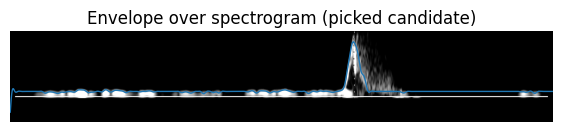

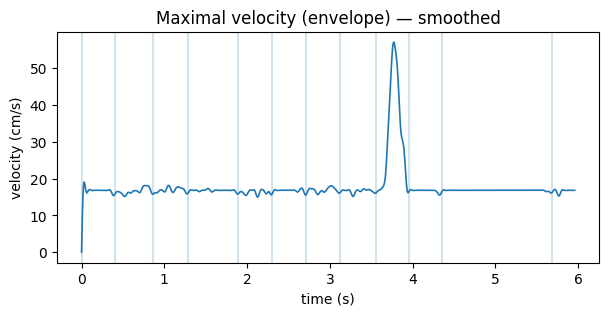

In [43]:
import matplotlib.pyplot as plt

# Overlay envelope on the masked image (just to see if it hugs the bright ridge)
x = np.arange(len(v_best))
y_row = cal["v0_row"] - v_best * cal["px_per_cms"]

plt.figure(figsize=(7,3))
plt.imshow(im_for_thresh, cmap='gray', origin='upper')
plt.plot(x, y_row, linewidth=1.0)
plt.title("Envelope over spectrogram (picked candidate)")
plt.axis('off'); plt.show()

# Plot velocity waveform with detected onsets
t = x / fs_env
plt.figure(figsize=(7,3))
plt.plot(t, v_best, lw=1.2)
[plt.axvline(t[i], alpha=0.2) for i in on_best]
plt.xlabel("time (s)"); plt.ylabel("velocity (cm/s)")
plt.title("Maximal velocity (envelope) — smoothed")
plt.show()


### 8. Post-filtering (median + low-pass)
Wadehn & Heldt used a 4th-order Butterworth (fc≈16 Hz at their sampling) and a short 1D median to clean spikes. You’ll adapt fc to your envelope sampling rate (fs = px_per_s).

In [14]:
def smooth_envelope(v, fs):
    v_med = medfilt(v, kernel_size=3)  # ~14 ms in their setup; OK to keep 3
    # low-pass at e.g. 12–16 Hz (envelope changes slower than spectrogram sampling)
    fc = min(16.0, 0.4*fs)            # cap at 0.4*Nyquist
    b,a = butter(4, fc/(fs/2), btype='low')
    return filtfilt(b,a, v_med)

# Build candidate envelopes over threshold grid
v_candidates = []
for thr in thr_grid:
    # binarize every frame, median-filter each, OR median over time then filter (choose 1)
    # simple approach: median over time -> filter once
    im = np.median(spec_n, axis=0)
    _, im_f = cv2.threshold(im, thr, 1, cv2.THRESH_BINARY)
    im_f = cv2.medianBlur((im_f*255).astype(np.uint8), kx|1)  # rough despeckle fallback
    env_px = trace_envelope(np.repeat(im_f[None,...]>0, 1, axis=0))
    v = px_to_velocity(env_px)
    v_candidates.append(v)

fs_env = cal.px_per_s  # “samples per second” along columns
v_best = choose_best_candidate(v_candidates, fs_env)
v_smooth = smooth_envelope(v_best, fs_env)


NameError: name 'thr_grid' is not defined

### 9. Beat metrics and windowed features

In [15]:
def beat_metrics(v, fs, onsets):
    beats=[]
    for i in range(len(onsets)-1):
        seg = v[onsets[i]:onsets[i+1]]
        PSV = np.nanmax(seg)
        EDV = np.nanmin(seg[-int(0.2*len(seg)):])  # crude: min in last 20% of beat
        MFV = np.nanmean(seg)
        PI  = (PSV - EDV) / (MFV + 1e-6)
        RI  = (PSV - EDV) / (PSV + 1e-6)
        beats.append(dict(PSV=PSV, EDV=EDV, MFV=MFV, PI=PI, RI=RI))
    return beats

sqi, on = beat_quality(v_smooth, fs_env)
bm = beat_metrics(v_smooth, fs_env, on)

# Windowed summary (e.g., 20 s)
win = int(20*fs_env)
features=[]
for start in range(0, len(v_smooth)-win, win):
    end = start+win
    # beats fully inside window
    inside = (on>=start) & (on<end)
    if inside.sum()>=3:
        idx = np.where(inside)[0]
        vals = [bm[i] for i in idx if sqi[i] >= 30]  # keep good beats
        if len(vals)>=3:
            features.append({
                "t0_s": start/fs_env,
                "PSV_mean": np.mean([d["PSV"] for d in vals]),
                "EDV_mean": np.mean([d["EDV"] for d in vals]),
                "MFV_mean": np.mean([d["MFV"] for d in vals]),
                "PI_mean":  np.mean([d["PI"]  for d in vals]),
                "RI_mean":  np.mean([d["RI"]  for d in vals]),
                "artifact_pct": 100*(1 - len(vals)/len(idx))
            })


NameError: name 'v_smooth' is not defined